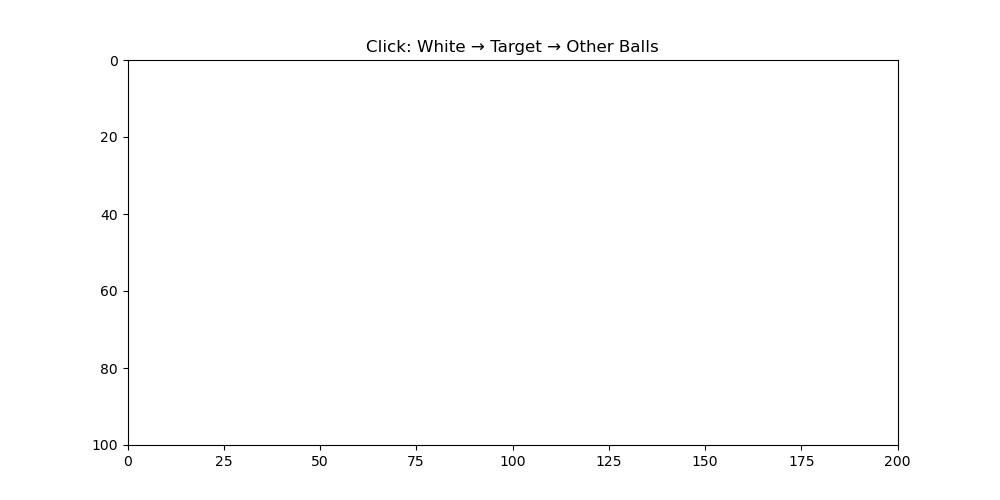

In [1]:
%matplotlib widget

import math
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
TABLE_W, TABLE_H = 200, 100
BALL_R = 2.5
MAX_CUT_ANGLE = 60     # relaxed human limit

POCKETS = {
    "TL": (0, 0),
    "TM": (100, 0),
    "TR": (200, 0),
    "BL": (0, 100),
    "BM": (100, 100),
    "BR": (200, 100)
}

# =========================
# UTILS
# =========================
def dist(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])

def angle_between(v1, v2):
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    m1 = math.hypot(*v1)
    m2 = math.hypot(*v2)
    if m1 == 0 or m2 == 0:
        return 180
    return math.degrees(math.acos(max(-1, min(1, dot / (m1*m2)))))

def segment_hits_ball(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c

    lab = dist(a, b)
    if lab == 0:
        return False

    t = ((cx - ax)*(bx - ax) + (cy - ay)*(by - ay)) / (lab**2)
    t = max(0, min(1, t))
    px = ax + t*(bx - ax)
    py = ay + t*(by - ay)

    return dist((px, py), c) < BALL_R * 2

# =========================
# SHOT COMPUTATION
# =========================
def compute_shots(white, target, blockers):
    shots = []
    fallback = []

    for pname, pocket in POCKETS.items():
        # Ghost ball
        vx = pocket[0] - target[0]
        vy = pocket[1] - target[1]
        d = math.hypot(vx, vy)
        if d == 0:
            continue

        gx = target[0] - vx / d * BALL_R * 2
        gy = target[1] - vy / d * BALL_R * 2
        ghost = (gx, gy)

        # Cut angle
        v1 = (ghost[0] - white[0], ghost[1] - white[1])
        v2 = (pocket[0] - target[0], pocket[1] - target[1])
        cut = angle_between(v1, v2)

        # Fallback always stored
        fallback.append({
            "type": "Direct",
            "pocket": pname,
            "score": cut,
            "path": [white, ghost, pocket]
        })

        if cut > MAX_CUT_ANGLE:
            continue

        blocked = False
        for b in blockers:
            if segment_hits_ball(white, ghost, b):
                blocked = True
            if segment_hits_ball(target, pocket, b):
                blocked = True
        if blocked:
            continue

        score = cut * 1.2 + dist(white, ghost) * 0.02

        shots.append({
            "type": "Direct",
            "pocket": pname,
            "score": score,
            "path": [white, ghost, pocket]
        })

    if not shots:
        print("⚠️ fallback used")
        return fallback

    return shots

# =========================
# DRAWING
# =========================
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, TABLE_W)
ax.set_ylim(TABLE_H, 0)
ax.set_aspect("equal")
ax.set_title("Click: White → Target → Other Balls")

white = None
target = None
others = []

def redraw():
    ax.clear()
    ax.set_xlim(0, TABLE_W)
    ax.set_ylim(TABLE_H, 0)
    ax.set_aspect("equal")
    ax.set_title("Click: White → Target → Other Balls")

    # pockets
    for p in POCKETS.values():
        ax.plot(p[0], p[1], "ko")

    if white:
        ax.add_patch(plt.Circle(white, BALL_R, fc="white", ec="black"))

    if target:
        ax.add_patch(plt.Circle(target, BALL_R, fc="red"))

    for b in others:
        ax.add_patch(plt.Circle(b, BALL_R, fc="blue"))

    if white and target:
        shots = compute_shots(white, target, others)
        shots = sorted(shots, key=lambda s: s["score"])[:2]

        colors = ["red", "orange"]
        labels = ["BEST 1", "BEST 2"]

        for i, s in enumerate(shots):
            xs = [p[0] for p in s["path"]]
            ys = [p[1] for p in s["path"]]
            ax.plot(xs, ys, color=colors[i], linewidth=3)

            ax.text(
                xs[0] + 3,
                ys[0] + 6 + i * 8,
                f"{labels[i]}: {s['type']} → {s['pocket']}",
                fontsize=10,
                color=colors[i],
                bbox=dict(facecolor="white", alpha=0.85)
            )

    plt.draw()

def on_click(event):
    global white, target, others
    if event.inaxes != ax:
        return

    pos = (event.xdata, event.ydata)

    if white is None:
        white = pos
    elif target is None:
        target = pos
    else:
        others.append(pos)

    redraw()

fig.canvas.mpl_connect("button_press_event", on_click)
plt.show()
